### Problem 1: Td(0) Prediction

Here, I have used TD(0) Prediction algorithm to predict the value of the states for the uniform random policy of selecting each action ('left', 'right', 'up', and 'down') with 0.25 probability given a state s. The Td(0) Prediction algorithm is run for 100 episodes during which the value of the states are updated. After, this 100 more episodes are simulated. The squared error at each episode (of these extra 100 simualted episodes) is found using $SE_t = (V_{\pi}(s) - V(s))^2$ where $V_{\pi}(s)$ is the true value of the states calculated using policy evaluation and V(s) is the TD estimate of the states. We sum these squares for all states and take the average to have the mean squared error for each extra episodes simulated from 101 to 200. The average of these mean squared errors over these 100 simulated episodes gives us the required mean squared error. Given a value of the step size $\alpha$, this process is repeated to find the mean squared value error for the given alpha. The plot shows the behaviour of the mean squarred error across different values of alpha.

In [1]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

#### Building the gridworld environment

In [2]:
#building the environment
class Environment:
    def __init__(self, M,N, holes, terminal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.shape = (M,N)
        self.holes = holes
        self.terminal_state = terminal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
        self.prob_agent_action = [0.8, 0.1, 0.05, 0.05]
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state == (6,3):
                r[state] = -15
            elif state == (6,6):
                r[state] = 15
            else:
                r[state] = 0
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner_and_hole((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'
    
    def check_corner_and_hole(self, s): 
        #function to check if the updates state goes out of the gridworld or goes into holes. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        x1, y1 = s
        stay_same = False
        for hole in self.holes:
            if (x1,y1) == hole:
                stay_same = True

        if x1<1 or x1>6:
            stay_same = True
        if y1<1 or y1>6:
            stay_same = True
        
        return stay_same
    
    def get_new_state(self, s, a): 
        #this is the function to take the agent to an update state given the agent's choice of action and current state.
        #This encapsulates the dynamics of the environment and is not known to the agent. The agent only
        #produces the current state s and his choice of action a, to which the environment returns his new state s1.
        x, y = s
        t = random.random()
        
        if t<=0.8: #agent's action succeeds
            x1,y1 = self.agent_move(s,a)
            return (x1,y1)
        
        elif 0.8<t<=0.9: #agent stays in same state
            return s
        
        elif 0.9<t<=0.95: #move in a 90 degree clockwise direction
            a1 = self.move_clockwise90(a)
            s1 = self.agent_move(s, a1)
            return s1
        else: #move in a -90 degree clockwise direction
            a1 = self.move_anti_clockwise90(a)
            s1 = self.agent_move(s, a1)
            
            return s1
            

In [3]:
gridworld = Environment(6,6 , [(4,3),(5,3)], (6,6))

#### Computing the value of states using Policy Evaluation.

In [4]:
def compute_value(env = gridworld, epsilon = 1e-8, gamma = 0.9):
    #function for policy evaluation to compute value of states for the uniform random policy
    delta = np.inf
    V = {}
    actions = ['L','R','U','D']
    pi = {}
    
    #initializing the value of all states and the uniform random policy of taking each action with prob 0.25
    for s in env.states:
        V[s] = 0
        pi[s] = {}
        for a in actions:
            pi[s][a] = 0.25

    #loop forever till abs(new value - old value) is withing epsilon
    while delta > epsilon:
        max_diff = -np.inf
        for s in env.states:
            if s!=env.terminal_state:
                v = 0
                for a in pi[s]:
                    p = pi[s][a]
                    #with prob 0.8 take action a to get to state s1 with reward r1
                    s1 = env.agent_move(s,a)
                    r1 = env.rewards[s1]

                    v1 = 0.8 * (r1 + gamma * V[s1])

                    #with prob 0.1 stay in same state s
                    r2 = env.rewards[s]
                    v2 = 0.1 * (r2 + gamma * V[s])

                    #with prob 0.05 take action in direction +90 degree clockwise direction
                    a3 = env.move_clockwise90(a)
                    s3 = env.agent_move(s, a3)
                    r3 = env.rewards[s3]
                    v3 = 0.05 * (r3 + gamma * V[s3])

                    #with prob 0.05 take action in direction -90 degree clockwise direction

                    a4 = env.move_anti_clockwise90(a)
                    s4 = env.agent_move(s, a4)
                    r4 = env.rewards[s4]
                    v4 = 0.05 * (r4 + gamma * V[s4])

                    v = v + (p * (v1+v2+v3+v4))
                    

                diff = abs(V[s] - v)
                V[s] = v
                max_diff = max(max_diff, diff)

        delta = max_diff
        
    return V

In [5]:
# V contains the value of states evaluated using policy evaluation and is the true state value for the uniform random policy.
# This value is going to be compared with the TD estimate to compute the mean squared error
V = compute_value()
V

{(1, 3): -0.27642130303408846,
 (6, 6): 0,
 (5, 6): 5.428752086365931,
 (2, 1): -0.7682316919867802,
 (6, 2): -18.202778672087756,
 (1, 6): 0.0674715652078087,
 (5, 1): -5.954288579506516,
 (2, 5): 0.005714819711983525,
 (1, 2): -0.40649480892936374,
 (3, 3): -0.6621033994813392,
 (5, 5): 0.5071660442594326,
 (4, 4): -1.2840003336659664,
 (6, 3): -29.301131575796326,
 (1, 5): -0.022069683166935392,
 (3, 6): 0.5918009837333996,
 (2, 2): -0.6727476405258225,
 (4, 1): -3.173690884069524,
 (1, 1): -0.47105368791522395,
 (6, 4): -14.12843836659732,
 (3, 2): -1.4395057149396342,
 (2, 6): 0.1903320760526663,
 (5, 4): -4.266173444005633,
 (4, 5): 0.24488791723038597,
 (5, 2): -7.942819537533008,
 (1, 4): -0.1502940589464806,
 (2, 3): -0.40897942059492143,
 (4, 2): -3.5937713998598255,
 (6, 5): 0.8716499724036371,
 (3, 5): 0.08402948769442829,
 (4, 6): 1.7932887647332514,
 (6, 1): -9.6867447798331,
 (3, 1): -1.5402674582274198,
 (3, 4): -0.4647897341603413,
 (2, 4): -0.2266104937223239}

#### TD(0) Prediction  

In [6]:
#building the TD Agent for TD(0) prediction for the uniform random policy of selecting each action with probability 0.25
class TD_Agent:
    def __init__(self, alpha, gamma, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.alpha = alpha
        self.gamma = gamma #discount parameter
        self.V = self.initialize_value_states(env)
        
        
    
    def initialize_value_states(self, env):
        #function to initialize the value of the states
        v_s = {}
        for state in env.states:
            v_s[state] = 0
        return v_s
    
    
    def TD_update(self, env, start_state = (1,1)):
        #function to update the value of states
        s = start_state
        while s!= env.terminal_state:
            #all actions are possible with uniform proability 
            a = np.random.choice(self.actions)
            s1 = env.get_new_state(s,a)
            r = env.rewards[s1]
            
            delta_t = (r + (self.gamma*self.V[s1])) - self.V[s]
            self.V[s] = self.V[s] + (self.alpha * delta_t)
            
            s = s1
        
    def play(self, env, episodes = 100):
        #function to play the TD agent for 100 episodes
        for episode_no in range(episodes):
            self.TD_update(env)
    
            

#### Finding mean squared error

In [12]:
 def find_mse_value_states(agent, V, env = gridworld,start_state = (1,1), episodes = 100):
        #function to find the mean squared TD error of each state. 
        
        #td_errors = []
        t = 0
        td_error_sum = 0
        
        
        
        for i in range(episodes):
            s = start_state
            v_ep = agent.V.copy()
            
            while s!=env.terminal_state:
                t+=1
                a = np.random.choice(agent.actions, p = [0.25, 0.25, 0.25, 0.25])
                s1 = env.get_new_state(s,a)
                r = env.rewards[s1]

                v_ep[s] = v_ep[s] + (agent.alpha*(r + (agent.gamma*v_ep[s1]) - v_ep[s]))
                #td_error_s = V[s] - agent.V[s] 
                #td_error_s = r + (agent.gamma* agent.V[s1]) - agent.V[s]
                #td_error_sum += (td_error_s**2)
                s = s1
                
            mse_ep = 0
            for s in env.states:
                error = V[s] - v_ep[s]
                mse_ep += (error**2)
                
            mse_ep/=len(env.states)
            td_error_sum +=mse_ep

            #mse = td_error_sum/n
            #td_errors.append(mse)    
        
        return (td_error_sum/episodes)

In [13]:
def problem1():
    alphas = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    #alphas = np.linspace(0.001, 0.1, 100)
    mean_squared_td_errors = []
    for alpha in tqdm(alphas):
        agent = TD_Agent(alpha = alpha, gamma = 0.9, env = gridworld)
        agent.play(gridworld)
        mse_td_error = find_mse_value_states(agent, V)
        mean_squared_td_errors.append(mse_td_error)
    
    print ("alpha\tMSE")
    for i in range(len(alphas)):
        print (alphas[i], mean_squared_td_errors[i])
        
    plt.plot(alphas, mean_squared_td_errors)
    plt.xlabel("Step Size")
    plt.ylabel("Mean squared Td error")
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]

alpha	MSE
0.0001 48.16592267888045
0.0005 43.799154455525404
0.001 38.47126810969493
0.002 35.762218763835634
0.005 19.8801459565938
0.01 11.034999779449283
0.02 2.3004128908537127
0.05 0.7810092986815761
0.1 3.0720831551284213
0.2 5.080750365059172


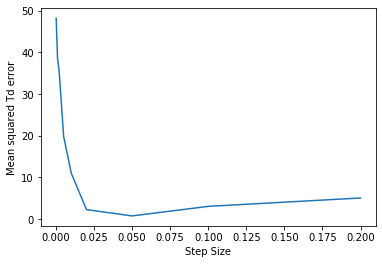

In [14]:
problem1()

In [16]:
agent = TD_Agent(alpha = 0.05, gamma = 0.9, env = gridworld)
agent.play(gridworld)
    
agent.V[(1,1)]

-0.4020074711510651